### Cycle GAN Images

### Introduction

This project aims to generate Monte-style images from input photos using CycleGAN inspired by Amy Jang's implementation and tutorial for the Kaggle competition.

### Dataset

The dataset consists of two different groups of images. One is a photo of real landscapes and another are paintings by Monet. There are several thousand real images and about one thousand Monet paintings. Each image was resized to 256x256 pixels.

### Modeling Process

I started with Amy Jang's CycleGAN implementation that uses generator and discriminators. The generators transform images, while the discriminators determine the authenticity of the generated images. First the models were trained with standard and default hyperparameters. Further modeling included modifying generator and discriminator architectures, and adjusting learning rates. As I had issues utilizing the Kaggle notebook online, I created my project utilizing Jupyter Notebook on my local device and utilized my computer's GPU for training. Therefore I was unable to submit my notebook to Kaggle for the competition itself.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import numpy as np

/Users/Monica/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.14.0


In [3]:
# Load the Monet dataset
current_dir = os.getcwd()

monet_dataset_path = os.path.join(current_dir, 'monet_jpg/') # Update this path
photo_dataset_path = os.path.join(current_dir, 'photo_jpg/')   # Update this path

def load_image(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Use decode_jpeg for .jpg files
        image = tf.image.resize(image, [256, 256])
        image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
        return image
    except tf.errors.InvalidArgumentError:
        print(f"Invalid image file: {image_path}")
        return None  # Return None for invalid images

def load_data(dataset_path):
    # Define valid image extensions
    valid_extensions = {'.jpg', '.jpeg', '.png'}

    # Get image paths and filter out unwanted files
    image_paths = [
        os.path.join(dataset_path, fname) 
        for fname in os.listdir(dataset_path)
        if os.path.splitext(fname)[1].lower() in valid_extensions
    ]

    images = [load_image(image_path) for image_path in image_paths]
    # Filter out None images
    images = [img for img in images if img is not None]
    return tf.data.Dataset.from_tensor_slices(images)


In [4]:
# Create datasets
monet_ds = load_data(monet_dataset_path).batch(1)
photo_ds = load_data(photo_dataset_path).batch(1)

2024-10-20 21:08:37.261398: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-10-20 21:08:37.261520: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-10-20 21:08:37.261551: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-10-20 21:08:37.261694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-20 21:08:37.261762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### First Iteration

Baseline architecture

In [29]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(256, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)


In [30]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

In [31]:
# Example usage: generate a Monet-style painting from a photo
example_photo = next(iter(photo_ds))
example_monet = next(iter(monet_ds))

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Monet Photo")
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.axis("off")
plt.show()


In [32]:
class CycleGan(keras.Model):
    def __init__(self,
                 monet_generator,
                 photo_generator,
                 monet_discriminator,
                 photo_discriminator,
                 lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,
                m_gen_optimizer,
                p_gen_optimizer,
                m_disc_optimizer,
                p_disc_optimizer,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Generate images
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Identity mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator predictions
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Calculate generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Calculate cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Calculate total generator losses
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Calculate discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [33]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [34]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [35]:
with strategy.scope():
    def cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [36]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [37]:
# Define optimizers
with strategy.scope():
    m_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    p_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    m_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    p_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    
    # Create the CycleGAN model
    cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    
    # Compile the model
    cycle_gan_model.compile(
        m_gen_optimizer=m_gen_optimizer,
        p_gen_optimizer=p_gen_optimizer,
        m_disc_optimizer=m_disc_optimizer,
        p_disc_optimizer=p_disc_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=cycle_loss,
        identity_loss_fn=identity_loss
    )
    cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

Epoch 1/5
300/300 [==============================] - 83s 223ms/step - monet_gen_loss: 5.0264 - photo_gen_loss: 5.1623 - monet_disc_loss: 0.6682 - photo_disc_loss: 0.6430
Epoch 2/5
300/300 [==============================] - 70s 232ms/step - monet_gen_loss: 3.4967 - photo_gen_loss: 3.6193 - monet_disc_loss: 0.6723 - photo_disc_loss: 0.6304
Epoch 3/5
300/300 [==============================] - 67s 224ms/step - monet_gen_loss: 3.4578 - photo_gen_loss: 3.5898 - monet_disc_loss: 0.6412 - photo_disc_loss: 0.6009
Epoch 4/5
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 3.3684 - photo_gen_loss: 3.5516 - monet_disc_loss: 0.6346 - photo_disc_loss: 0.5795
Epoch 5/5
300/300 [==============================] - 70s 235ms/step - monet_gen_loss: 3.2573 - photo_gen_loss: 3.4064 - monet_disc_loss: 0.6202 - photo_disc_loss: 0.5884


In [38]:
_, ax = plt.subplots(8, 2, figsize=(12, 20))
for i, img in enumerate(photo_ds.take(8)):
    prediction = cycle_gan_model.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Second iteration
Decreasing learning rate of generator and increasing learning rate of optimizer

In [40]:
with strategy.scope():
    # Define optimizers
    m_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005, beta_1=0.5)
    p_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005, beta_1=0.5)
    m_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    p_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    
    # Create the CycleGAN model
    cycle_gan_model2 = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    
    # Compile the model
    cycle_gan_model2.compile(
        m_gen_optimizer=m_gen_optimizer,
        p_gen_optimizer=p_gen_optimizer,
        m_disc_optimizer=m_disc_optimizer,
        p_disc_optimizer=p_disc_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=cycle_loss,
        identity_loss_fn=identity_loss
    )
    
    cycle_gan_model2.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=5
    )

Epoch 1/5
300/300 [==============================] - 81s 217ms/step - monet_gen_loss: 2.3500 - photo_gen_loss: 2.3197 - monet_disc_loss: 0.6150 - photo_disc_loss: 0.6268
Epoch 2/5
300/300 [==============================] - 67s 224ms/step - monet_gen_loss: 2.2882 - photo_gen_loss: 2.2656 - monet_disc_loss: 0.6069 - photo_disc_loss: 0.6206
Epoch 3/5
300/300 [==============================] - 67s 224ms/step - monet_gen_loss: 2.2583 - photo_gen_loss: 2.2398 - monet_disc_loss: 0.6046 - photo_disc_loss: 0.6168
Epoch 4/5
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 2.2332 - photo_gen_loss: 2.2235 - monet_disc_loss: 0.6059 - photo_disc_loss: 0.6156
Epoch 5/5
300/300 [==============================] - 68s 227ms/step - monet_gen_loss: 2.2167 - photo_gen_loss: 2.2103 - monet_disc_loss: 0.6058 - photo_disc_loss: 0.6142


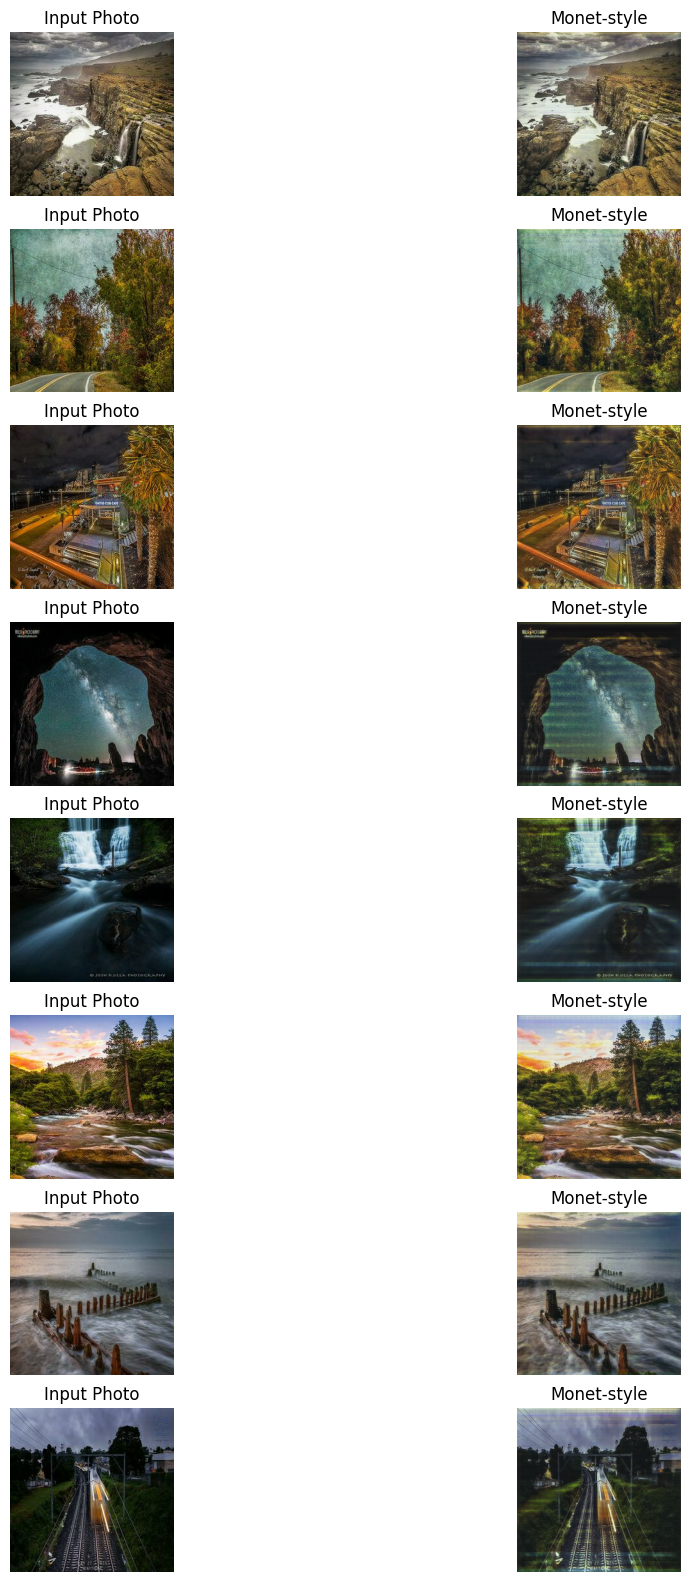

In [41]:
_, ax = plt.subplots(8, 2, figsize=(12, 20))
for i, img in enumerate(photo_ds.take(8)):
    prediction = cycle_gan_model2.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Third iteration

Increasing learning rate for generator and returning to baseline learning rate for discriminator

In [44]:
with strategy.scope():
    # Define optimizers
    m_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    p_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    m_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    p_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    
    # Create the CycleGAN model
    cycle_gan_model3 = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    
    # Compile the model
    cycle_gan_model3.compile(
        m_gen_optimizer=m_gen_optimizer,
        p_gen_optimizer=p_gen_optimizer,
        m_disc_optimizer=m_disc_optimizer,
        p_disc_optimizer=p_disc_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=cycle_loss,
        identity_loss_fn=identity_loss
    )
    
    cycle_gan_model3.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=5
    )

Epoch 1/5
300/300 [==============================] - 82s 218ms/step - monet_gen_loss: 2.4578 - photo_gen_loss: 2.4235 - monet_disc_loss: 0.6555 - photo_disc_loss: 0.6483
Epoch 2/5
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 2.3983 - photo_gen_loss: 2.4242 - monet_disc_loss: 0.6468 - photo_disc_loss: 0.6602
Epoch 3/5
300/300 [==============================] - 68s 226ms/step - monet_gen_loss: 2.3979 - photo_gen_loss: 2.3720 - monet_disc_loss: 0.6161 - photo_disc_loss: 0.7024
Epoch 4/5
300/300 [==============================] - 68s 227ms/step - monet_gen_loss: 2.3617 - photo_gen_loss: 2.3040 - monet_disc_loss: 0.6079 - photo_disc_loss: 0.7118
Epoch 5/5
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 2.3354 - photo_gen_loss: 2.2587 - monet_disc_loss: 0.6077 - photo_disc_loss: 0.6875


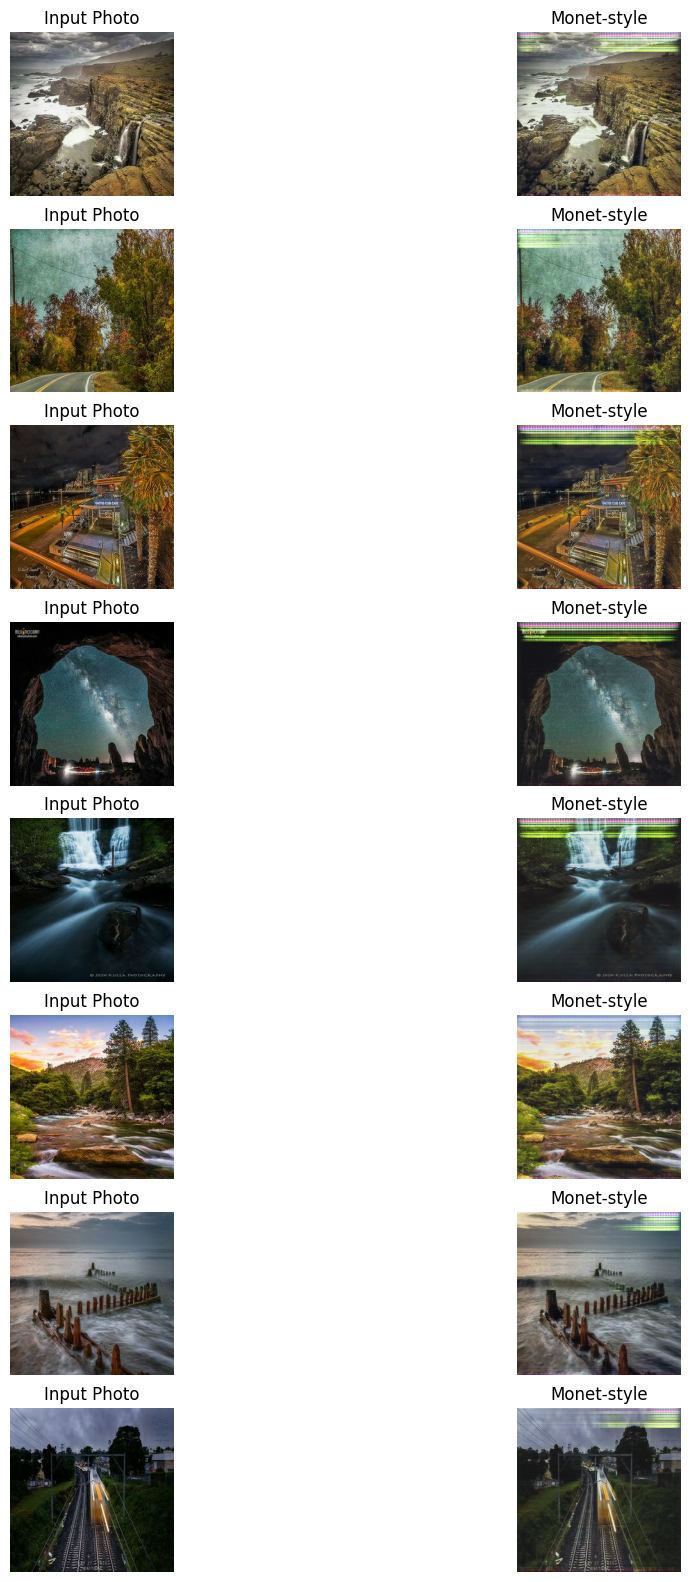

In [45]:
_, ax = plt.subplots(8, 2, figsize=(12, 20))
for i, img in enumerate(photo_ds.take(8)):
    prediction = cycle_gan_model3.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Fourth Iteration

Modifying CycleGAN Architecture and decreasing learning rate for generator and discriminator

In [46]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator2():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator2():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(256, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)


In [47]:
with strategy.scope():
    monet_generator = Generator2()
    photo_generator = Generator2()
    monet_discriminator = Discriminator2()
    photo_discriminator = Discriminator2()

In [49]:
# Define optimizers
with strategy.scope():
    m_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    p_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    m_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    p_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.002, beta_1=0.5)
    
    # Create the CycleGAN model
    cycle_gan_model4 = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    
    # Compile the model
    cycle_gan_model4.compile(
        m_gen_optimizer=m_gen_optimizer,
        p_gen_optimizer=p_gen_optimizer,
        m_disc_optimizer=m_disc_optimizer,
        p_disc_optimizer=p_disc_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=cycle_loss,
        identity_loss_fn=identity_loss
    )
    
    cycle_gan_model4.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=5
    )

Epoch 1/5
300/300 [==============================] - 125s 298ms/step - monet_gen_loss: 3.7930 - photo_gen_loss: 3.8287 - monet_disc_loss: 0.6832 - photo_disc_loss: 0.6900
Epoch 2/5
300/300 [==============================] - 90s 301ms/step - monet_gen_loss: 3.0223 - photo_gen_loss: 3.0274 - monet_disc_loss: 0.6560 - photo_disc_loss: 0.6720
Epoch 3/5
300/300 [==============================] - 90s 301ms/step - monet_gen_loss: 2.7769 - photo_gen_loss: 2.8581 - monet_disc_loss: 0.6462 - photo_disc_loss: 0.6391
Epoch 4/5
300/300 [==============================] - 89s 295ms/step - monet_gen_loss: 2.6572 - photo_gen_loss: 2.7707 - monet_disc_loss: 0.6405 - photo_disc_loss: 0.6246
Epoch 5/5
300/300 [==============================] - 88s 294ms/step - monet_gen_loss: 2.5818 - photo_gen_loss: 2.6809 - monet_disc_loss: 0.6253 - photo_disc_loss: 0.6145


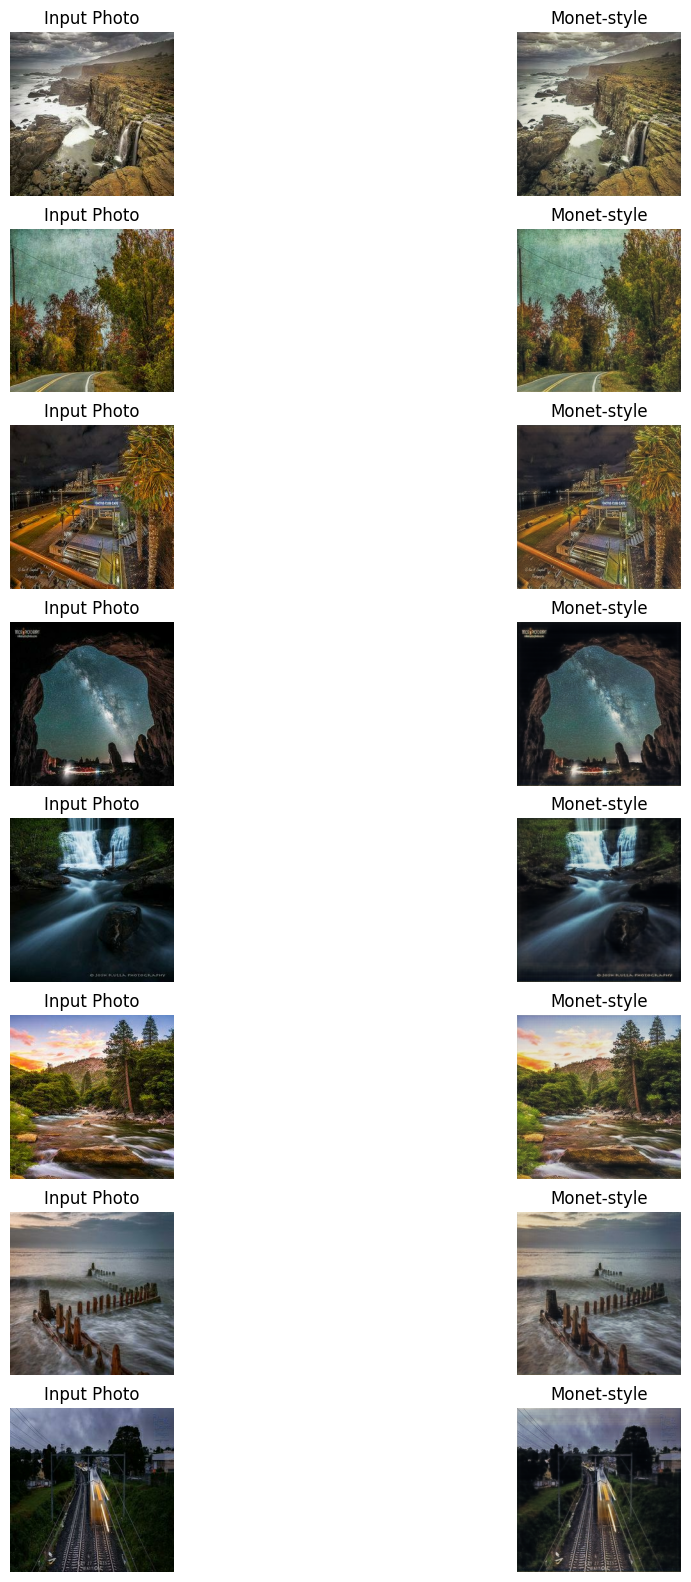

In [50]:
_, ax = plt.subplots(8, 2, figsize=(12, 20))
for i, img in enumerate(photo_ds.take(8)):
    prediction = cycle_gan_model4.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Results Discussion

Results from the four different iterations underscore the importance of balancing the training of generators and sicriminators. I'm not confident that any of the models were able to successfully learn the Monet style of images since my generated images still look closely to the real images. Adjusting the learning rates did however, affect how well my generated images were able to capture the real input photos in terms of colors and their intensity. In order to improve the capture of the Monet paintings, I would probably need to take a closer look at the generator architecture.